## Data Loading

In [1]:
import pandas as pd
from helpers import *
%matplotlib inline

Firstly, let's create our data-frame from our source data. Additionally, we'll transform the `Score_home` and `Score_away` columns into our target variable such that:
$$
y = \cases{-1 \\ 
            0 \\
            1 }
$$
using the helper function `score_to_win()`

In [2]:
DATA_SRC = '../Data/PL_site_2006_2018/masterdata.csv'
df = pd.read_csv(DATA_SRC)

# create win/lose label
df['target'] = df[['Score_home', 'Score_away']].apply(score_to_win, axis = 1)
df.sort_values('MatchID', inplace = True)
df.head()

,MatchID,Home_team,Away_team,Score_home,Score_away,Possession_home,Possession_away,Shots_on_target_home,Shots_on_target_away,Shots_home,...,year,Expenditures_home,Arrivals_home,Income_home,Departures_home,Expenditures_away,Arrivals_away,Income_away,Departures_away,target
373,5567,Arsenal,Aston Villa,1,1,72.9,27.1,7,3,24,...,2007,17.10,18,14.85,21,28.16,17,2.08,18,0
379,5568,Bolton,Spurs,2,0,37.8,62.2,4,2,13,...,2007,19.38,16,4.39,16,69.54,23,44.06,23,1
374,5569,Everton,Watford,2,1,47.0,53.0,2,7,8,...,2007,20.41,11,2.85,16,11.97,29,15.39,23,1
375,5570,Newcastle,Wigan,2,1,55.3,44.7,5,4,8,...,2007,36.34,8,12.74,14,29.24,23,27.73,25,1
376,5571,Portsmouth,Blackburn,3,0,44.3,55.7,11,3,21,...,2007,10.37,28,1.43,32,18.84,21,19.28,25,1


### Feature Extraction
Now, we must drop several variables from the above table in order to fit our model. We'll create `df_wo` to pass in. This leaves us with 24 avaiable features.

In [3]:
df_wo = df.drop(columns = ['target', 'MatchID', 'Home_team', 'Away_team', 'Score_home', 'Score_away', 'year'])
list(df_wo)

['Possession_home',
 'Possession_away',
 'Shots_on_target_home',
 'Shots_on_target_away',
 'Shots_home',
 'Shots_away',
 'Touches_home',
 'Touches_away',
 'Passes_home',
 'Passes_away',
 'Tackles_home',
 'Tackles_away',
 'Clearances_home',
 'Clearances_away',
 'Corners_home',
 'Corners_away',
 'Offsides_home',
 'Offsides_away',
 'Yellow_cards_home',
 'Yellow_cards_away',
 'Fouls_conceded_home',
 'Fouls_conceded_away',
 'Red_cards_home',
 'Red_cards_away',
 'Expenditures_home',
 'Arrivals_home',
 'Income_home',
 'Departures_home',
 'Expenditures_away',
 'Arrivals_away',
 'Income_away',
 'Departures_away']

## EDA
### Correlation

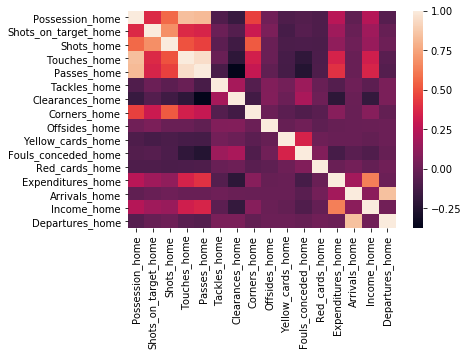

In [4]:
import seaborn as sns
home_features = [ f for f in list(df_wo) if '_home' in f ]
corr = df_wo[home_features].corr()
_ = sns.heatmap(corr)

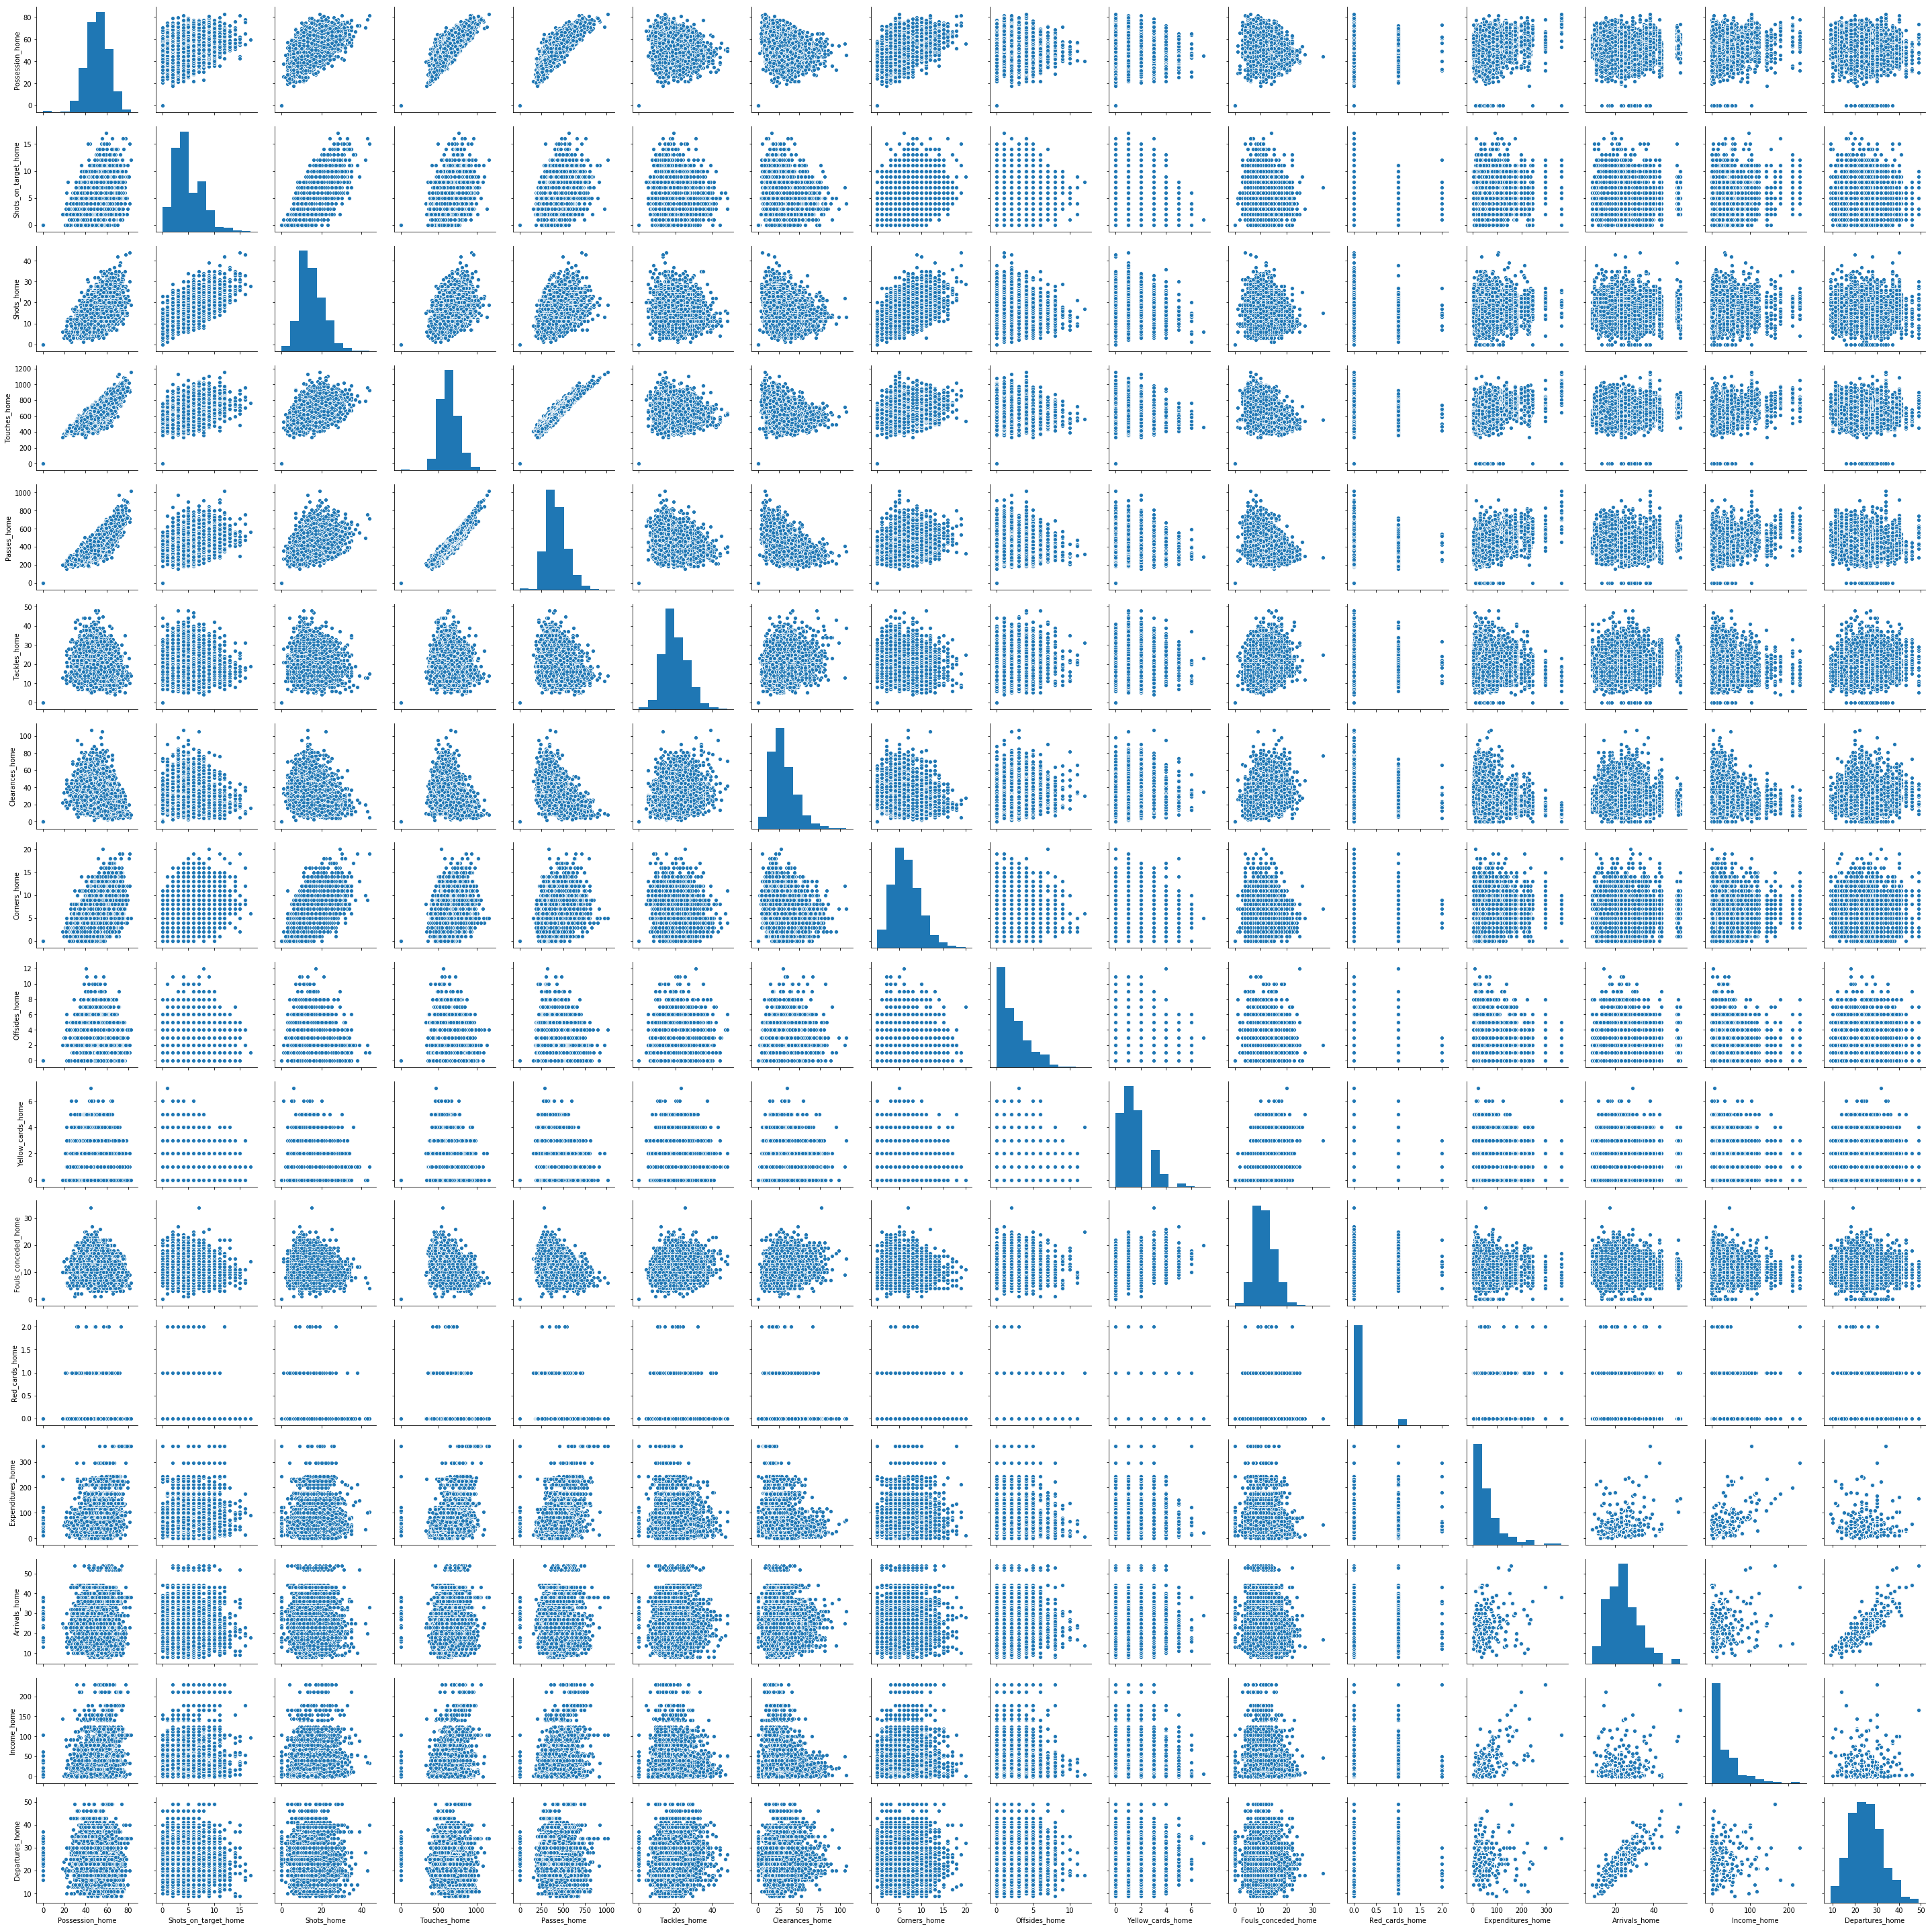

In [83]:
_ = sns.pairplot(df_wo[home_features])

### Variance Inflation
It is likely the case that several of the above variables are collinear. Now, in many models this might not have an effect as the coefficients for one variable will be high while the other will just be nullified. However, based on our correlation analysis it is clear some variables are capturing the same information. For example, possession is highly correlated with touches and passes. This isn't surprising, if a team possesses the ball for long stretches they are likely moving the ball around. 

We can use `statsmodels.stats.outliers_influence.variance_inflation_factor` to perform this analysis in Python.

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vifs = []
for i, feature in enumerate(list(df_wo)):
    vif_tup = (feature, variance_inflation_factor(df_wo.values, i))
    vifs.append( vif_tup )
vifs

[('Possession_home', 431.17404355511786),
 ('Possession_away', 430.16643323876826),
 ('Shots_on_target_home', 8.883291072896263),
 ('Shots_on_target_away', 7.44151459164484),
 ('Shots_home', 22.520041585871265),
 ('Shots_away', 18.837524258895257),
 ('Touches_home', 1679.5076507203844),
 ('Touches_away', 1632.1707715500168),
 ('Passes_home', 866.7726380734396),
 ('Passes_away', 832.1405275890884),
 ('Tackles_home', 14.49891835822139),
 ('Tackles_away', 14.866586844166966),
 ('Clearances_home', 12.486285927241799),
 ('Clearances_away', 14.771723609087307),
 ('Corners_home', 7.930314726148669),
 ('Corners_away', 6.517295988030291),
 ('Offsides_home', 2.770202203225566),
 ('Offsides_away', 2.6078753284393934),
 ('Yellow_cards_home', 3.0287265948844517),
 ('Yellow_cards_away', 3.5656105737383568),
 ('Fouls_conceded_home', 14.665480991067916),
 ('Fouls_conceded_away', 14.919611355366138),
 ('Red_cards_home', 1.1170833111416631),
 ('Red_cards_away', 1.1463853596258216),
 ('Expenditures_home'

These scores are really high. Typically, we'd like to ignore variables with VIF > 5. Clearly, we have a lot of shared information contained in this dataset.

## Feature Engineering
### Form
Often, in the sport, commentators and analysts point to a team's form (essentially the recent performance) as being somewhat important in their performance in an individual game. The thinking goes: if this team has played well, they will continue to play well. It is not dissimilar to the concept of momentum, in a way. Here, we'll use an exponential weighting scheme of previous results (where the importance of each game decays as we go further back in time).

In [6]:
scores = df[['MatchID', 'Home_team', 'Away_team', 'Score_home', 'Score_away']].values
gd = gd_vectors(scores)

away_form_linear = []
home_form_linear = []
away_form_exp = []
home_form_exp = []
for game in scores:
    id, home_team, away_team, _, _ = game
    away_form_exp.append( exponential_momentum(id, away_team, gd, alpha = .65) )
    home_form_exp.append( exponential_momentum(id, home_team, gd, alpha = .65) )
    away_form_linear.append( linear_momentum(id, away_team, gd) )
    home_form_linear.append( linear_momentum(id, home_team, gd) )


df_form = df.copy()
df_form['away_form_exp'] = pd.Series(away_form_exp)
df_form['home_form_exp'] = pd.Series(home_form_exp)
list(df_form)

['MatchID',
 'Home_team',
 'Away_team',
 'Score_home',
 'Score_away',
 'Possession_home',
 'Possession_away',
 'Shots_on_target_home',
 'Shots_on_target_away',
 'Shots_home',
 'Shots_away',
 'Touches_home',
 'Touches_away',
 'Passes_home',
 'Passes_away',
 'Tackles_home',
 'Tackles_away',
 'Clearances_home',
 'Clearances_away',
 'Corners_home',
 'Corners_away',
 'Offsides_home',
 'Offsides_away',
 'Yellow_cards_home',
 'Yellow_cards_away',
 'Fouls_conceded_home',
 'Fouls_conceded_away',
 'Red_cards_home',
 'Red_cards_away',
 'year',
 'Expenditures_home',
 'Arrivals_home',
 'Income_home',
 'Departures_home',
 'Expenditures_away',
 'Arrivals_away',
 'Income_away',
 'Departures_away',
 'target',
 'away_form_exp',
 'home_form_exp']

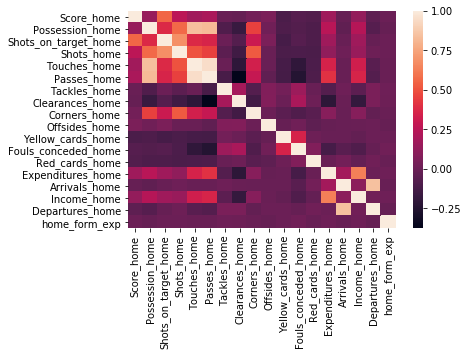

In [7]:
home_features = [ f for f in list(df_form) if 'home' in f ]
corr = df_form[home_features].corr()
_ = sns.heatmap(corr)

Unfortunately, given this result it doesn't appear that a team's form is highly correlated with its recent form. 

## Modeling

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [9]:
clfs = [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier(),
        KNeighborsClassifier()]

In [10]:
df_form.drop(columns = ['target', 'MatchID', 'Home_team', 'Away_team', 
                                 'Score_home', 'Score_away', 'year'], inplace = True)
X = df_wo.values
X_form = df_form.values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)
X_train_form, X_test_form, y_train_form, y_test_form = train_test_split(X_form, y, test_size = .2, random_state = 42)

In [11]:
for clf in clfs:
    clf.fit(X_train, y_train)
    print(type(clf))
    print("score = ", clf.score(X_test, y_test), "\n")

/home/thomas/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/thomas/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


<class 'sklearn.linear_model.logistic.LogisticRegression'>
score =  0.6513157894736842 

<class 'sklearn.ensemble.forest.RandomForestClassifier'>
score =  0.5625 



/home/thomas/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
score =  0.6348684210526315 

<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
score =  0.47478070175438597 



In [12]:
for clf in clfs:
    clf.fit(X_train_form, y_train_form)
    print(type(clf))
    print("score = ", clf.score(X_test_form, y_test_form), "\n")

/home/thomas/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/thomas/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


<class 'sklearn.linear_model.logistic.LogisticRegression'>
score =  0.6502192982456141 

<class 'sklearn.ensemble.forest.RandomForestClassifier'>
score =  0.5581140350877193 

<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
score =  0.6403508771929824 

<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
score =  0.4780701754385965 



Again, the inclusion of a form variable doesn't appear to make a material difference in our modeling procedure.

### Coefficient Investigation
Logistic Regression in particular provides a nice idea of the importance of our variables. Roughly, the larger coefficients suggest a higher importance of that feature. By inspection, we can potential use domain knowledge to drop collinear variables while keeping the best one. I.e. pick between `Touches` and `Passes`.

In [13]:
for i, feature in enumerate(list(df_form)):
    print(feature, ": ", clfs[0].coef_[:,i])

Possession_home :  [ 0.14157495  0.03369971 -0.17583874]
Possession_away :  [-0.18846756 -0.03475182  0.1891254 ]
Shots_on_target_home :  [-0.3074573  -0.17786645  0.41961381]
Shots_on_target_away :  [ 0.42548822 -0.08289813 -0.30014321]
Shots_home :  [ 0.02434259  0.01197657 -0.03290352]
Shots_away :  [-0.0350032   0.00372697  0.02183519]
Touches_home :  [-6.11377366e-03  5.06271713e-03  7.69519846e-05]
Touches_away :  [ 0.00747383 -0.00132275 -0.00338926]
Passes_home :  [-0.01082945 -0.00968373  0.01943119]
Passes_away :  [ 0.01195758  0.00370804 -0.01641788]
Tackles_home :  [-0.00697449  0.00457811  0.00191011]
Tackles_away :  [ 0.02262361 -0.01399011 -0.00366473]
Clearances_home :  [-0.04053146 -0.01053452  0.04411345]
Clearances_away :  [ 0.03138848  0.01198576 -0.04797664]
Corners_home :  [-0.00690869  0.00367339  0.01456125]
Corners_away :  [ 0.0130041   0.02395526 -0.0371187 ]
Offsides_home :  [-0.04144227 -0.01679137  0.05162239]
Offsides_away :  [ 0.01111798  0.00986008 -0.02

### Reduction of Feature Set
What if we drop some variables that are pretty collinear, or even proxies for one another. Perhaps then our models would perform better.

Based on the above, it would appear dropping shots in lieu of shots on target would be beneficial. This is perhaps unsurprising given we could take lots of bad shots, so in a sense we care about the quality of a shot, not just whether it happened. Similarly, possession seems to be more important than touches and passes. It stands to reason that most of the informational content of the touches and passes of a team are contained with the amount of possession they had during the game. 

In [15]:
features_to_drop = ['Shots_home', 'Shots_away', 'Touches_home', 
                                 'Touches_away', 'Possession_home', 'Possession_away',
                                 'Tackles_home', 'Tackles_away', 'Arrivals_home', 'Arrivals_away',
                                 'Departures_home', 'Departures_away', 'Corners_home', 'Corners_away',
                                 'Red_cards_home', 'Red_cards_away', 'Yellow_cards_home', 'Yellow_cards_away']
df_sub = df_form.drop(columns = features_to_drop)
print(list(df_sub))

['Shots_on_target_home', 'Shots_on_target_away', 'Passes_home', 'Passes_away', 'Clearances_home', 'Clearances_away', 'Offsides_home', 'Offsides_away', 'Fouls_conceded_home', 'Fouls_conceded_away', 'Expenditures_home', 'Income_home', 'Expenditures_away', 'Income_away', 'away_form_exp', 'home_form_exp']


Now, let's re-fit and see if we get any performance gains.

In [16]:
X_sub = df_sub.values
X_train, X_test, y_train, y_test = train_test_split(X_sub, y, test_size = .2, random_state = 42)

for clf in clfs:
    clf.fit(X_train, y_train)
    print(type(clf))
    print("score = ", clf.score(X_test, y_test), "\n")

/home/thomas/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/thomas/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


<class 'sklearn.linear_model.logistic.LogisticRegression'>
score =  0.6392543859649122 

<class 'sklearn.ensemble.forest.RandomForestClassifier'>
score =  0.6041666666666666 

<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
score =  0.6480263157894737 

<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
score =  0.4440789473684211 



Seems pretty sticky. 

In [17]:
for i, feature in enumerate(list(df_sub)):
    print(feature, ": ", clfs[0].coef_[:,i])

Shots_on_target_home :  [-0.28779734 -0.15577237  0.37549569]
Shots_on_target_away :  [ 0.39183594 -0.06993804 -0.29787836]
Passes_home :  [ 0.00039308 -0.00064092  0.00014216]
Passes_away :  [ 0.00071593 -0.00120107  0.00048484]
Clearances_home :  [-0.05170759 -0.0060828   0.04708522]
Clearances_away :  [ 0.04273026  0.01535122 -0.05785071]
Offsides_home :  [-0.06039058 -0.01469211  0.06240134]
Offsides_away :  [ 0.03587614  0.00291266 -0.03282983]
Fouls_conceded_home :  [ 0.00889551  0.01129095 -0.01647068]
Fouls_conceded_away :  [-0.03356922  0.02152823  0.00393476]
Expenditures_home :  [-0.00525175 -0.00019342  0.00340118]
Income_home :  [-0.00056503 -0.00030027  0.00148571]
Expenditures_away :  [ 0.00341809 -0.000401   -0.00308188]
Income_away :  [ 0.00229507  0.00043484 -0.00224047]
away_form_exp :  [-0.05189072 -0.00610476  0.04918812]
home_form_exp :  [ 0.03353995 -0.0180318   0.00241928]


Our gains are pretty minimal here.

In [18]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(df_sub.values)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = .2, random_state = 42)

for clf in clfs:
    clf.fit(X_train, y_train)
    print(type(clf))
    print("score = ", clf.score(X_test, y_test), "\n")

/home/thomas/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/thomas/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


<class 'sklearn.linear_model.logistic.LogisticRegression'>
score =  0.6392543859649122 

<class 'sklearn.ensemble.forest.RandomForestClassifier'>
score =  0.5932017543859649 

<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
score =  0.6480263157894737 

<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
score =  0.543859649122807 



## Form Reconsidered & Expected Goals
What if we consider that goal-scoring is just part of the picture as far as recent performance is concerned. After all, there is a bit of luck included in scoring goals. Of course, this is ultimately what we're interested in, but given that we have more features that just goals scored available, perhaps we should use them. 

We'll assume that the goals scored in each game is, in some sense, a function of a team's statistical performance over a recent window. That is, our $X$ input is a concatenation of multiple games. We can, then also provide an indicator variable as to whether they are playing home/away. This, now, becomes a regression problem, where our target variable is the actual score.

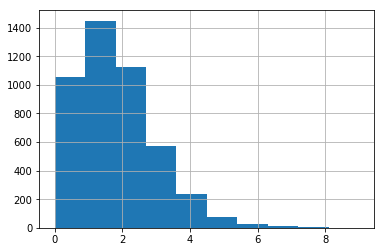

In [19]:
_ = df.Score_home.hist()

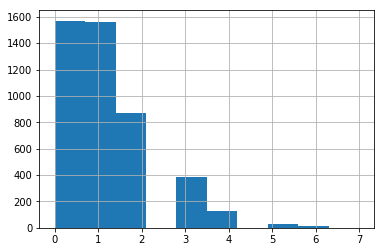

In [20]:
_ = df.Score_away.hist()

### Melted DataFrame
In order to perform this analysis, firstly we must melt out our above dataframe such that one row signifies a team's performance in an individual game. 

In [21]:
df.drop(columns = features_to_drop, inplace = True)
print(list(df))

['MatchID', 'Home_team', 'Away_team', 'Score_home', 'Score_away', 'Shots_on_target_home', 'Shots_on_target_away', 'Passes_home', 'Passes_away', 'Clearances_home', 'Clearances_away', 'Offsides_home', 'Offsides_away', 'Fouls_conceded_home', 'Fouls_conceded_away', 'year', 'Expenditures_home', 'Income_home', 'Expenditures_away', 'Income_away', 'target']


In [63]:
home_attributes = ['MatchID', 'Home_team', 'year'] + [a for a in list(df) if 'home' in a]
away_attributes = ['MatchID', 'Away_team', 'year'] + [a for a in list(df) if 'away' in a]

print(home_attributes, '\n')
print(away_attributes)

['MatchID', 'Home_team', 'year', 'Score_home', 'Shots_on_target_home', 'Passes_home', 'Clearances_home', 'Offsides_home', 'Fouls_conceded_home', 'Expenditures_home', 'Income_home'] 

['MatchID', 'Away_team', 'year', 'Score_away', 'Shots_on_target_away', 'Passes_away', 'Clearances_away', 'Offsides_away', 'Fouls_conceded_away', 'Expenditures_away', 'Income_away']


In [64]:
melted = []

for _, row in df.iterrows():
    home_team = [row[attr] for attr in away_attributes] + [1]
    away_team = [row[attr] for attr in home_attributes] + [0]
    melted.append(home_team)
    melted.append(away_team)

print(melted[0])

[5567, 'Aston Villa', 2007, 1, 3, 232, 51, 6, 19, 28.16, 2.08, 1]


In [67]:
features = ['MatchID', 'Team', 'year'] + [a.split('_')[0] for a in list(df) if 'home' in a] + ['IsHome']
print(features)

['MatchID', 'Team', 'year', 'Score', 'Shots', 'Passes', 'Clearances', 'Offsides', 'Fouls', 'Expenditures', 'Income', 'IsHome']


In [68]:
melted_df = pd.DataFrame(melted, columns = features)
melted_df.head()

,MatchID,Team,year,Score,Shots,Passes,Clearances,Offsides,Fouls,Expenditures,Income,IsHome
0,5567,Aston Villa,2007,1,3,232,51,6,19,28.16,2.08,1
1,5567,Arsenal,2007,1,7,631,14,2,10,17.10,14.85,0
2,5568,Spurs,2007,0,2,427,43,1,22,69.54,44.06,1
3,5568,Bolton,2007,2,4,243,20,3,22,19.38,4.39,0
4,5569,Watford,2007,1,7,321,32,1,15,11.97,15.39,1


Now, we can run our regression problem where our target variable is the goals scored by each team. We could also consider it a multi-class classification problem, but now we have some further flexibility.

In [69]:
from sklearn.linear_model import Lasso, Ridge, BayesianRidge, LinearRegression
regression_clfs = [LogisticRegression(), RandomForestClassifier(), 
                   Lasso(), Ridge(), BayesianRidge(), LinearRegression()]

In [70]:
scaler = StandardScaler()
# drop variables that are proxies for target
melted_df_wo = melted_df.drop(columns = ['MatchID', 'Team', 'year'])

X = melted_df_wo.drop(columns = ['Score']).values
X_scaled = scaler.fit_transform(X)
y = melted_df['Score'].values

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = .2, random_state = 42)

In [71]:
# build regression model for goals within a game (omit most recent year which we'll use for simulation)
list(melted_df)

['MatchID',
 'Team',
 'year',
 'Score',
 'Shots',
 'Passes',
 'Clearances',
 'Offsides',
 'Fouls',
 'Expenditures',
 'Income',
 'IsHome']

In [72]:
from sklearn.metrics import mean_squared_error

for clf in regression_clfs:
    clf.fit(X_train, y_train)
    print(type(clf))
    y_pred = clf.predict(X_test)
    print("rmse = ", mean_squared_error(y_test, y_pred) ** .5)

<class 'sklearn.linear_model.logistic.LogisticRegression'>
rmse =  1.2210442191785065
<class 'sklearn.ensemble.forest.RandomForestClassifier'>
rmse =  1.351336673950329
<class 'sklearn.linear_model.coordinate_descent.Lasso'>
rmse =  1.282620230552026
<class 'sklearn.linear_model.ridge.Ridge'>
rmse =  1.0336779262090077
<class 'sklearn.linear_model.bayes.BayesianRidge'>
rmse =  1.033773028777023
<class 'sklearn.linear_model.base.LinearRegression'>
rmse =  1.0336720216267545


/home/thomas/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/thomas/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/thomas/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The error here is pretty crummy, but at the very least we can perhaps try to use some linear regression methods in order to build out an expected goals model. In order to perform a season-long simulation, however, we also have to treat our game-level statistics as outputs of a function. 
### Season Simulation
Given that we've already argued previous form is an indicator of a team's performance. We'll use the game statistics dervied from the past 10 games as an input vector, along with the home/away indicator to predict the set of game-level statistics we have decided to use. Which is
```
['Shots_on_target', 'Passes', 'Clearances', 'Offsides', 'Fouls', 'Expenditures', 'Income', 'IsHome']
```

Note, in order to do this we have to construct a vector of the past 10 games for each team going into a game.

In [81]:
# we'll use the most recent year for our simulation
WINDOW = 10
max(melted_df.year)

2018

In [82]:
# which teams were in the league that year?
unique_teams = melted_df[melted_df.year == 2018].Team.unique()
unique_teams

array(['Leicester', 'Arsenal', 'Man City', 'Brighton', 'Burnley',
       'Chelsea', 'Huddersfield', 'Crystal Palace', 'Stoke', 'Everton',
       'West Ham', 'Man Utd', 'Spurs', 'Newcastle', 'Swansea',
       'Southampton', 'Liverpool', 'Watford', 'Bournemouth', 'West Brom'],
      dtype=object)

In [122]:
def build_stat_model(df, clf, teams, feature = None):
    X_as_list, y_as_list = [], []
    # TODO: add feature selection part
    for team in teams:
        team_df = df[df.Team == team]
        fit_df = df[team_df.year != 2018].drop(columns = ['MatchID', 'Team', 'year'])
        for i in range(0, team_df.shape[0] - WINDOW - 1):
            X_vec = fit_df.iloc[i:i + WINDOW].values.flatten()
            if X_vec.shape[0] == 90:
                X_as_list.append(X_vec)
                y_as_list.append(team_df.Score.values[i + WINDOW + 1])    
    
    # convert to vectors for model input
    X = np.vstack(X_as_list)
    y = np.array(y_as_list)
    clf.fit(X, y)
    return clf

In [ ]:
# now for each game in 2018 we have to simulate the match statistics & the resultant expected goals
# whi
